# 7: Working with Squidpy
Demonstrate the joint usage of spatialcells and squidpy to analyze 4i dataset by Gut et al, 2018

@author: Guihong Wan and Boshen Yan      
@date: Feb 15 2024   
@last updated: Feb 15 2024

Installing the environment

In [1]:
%%bash

# conda env create --name spatialcells_env --file=conda.yaml
# conda activate spatialcells_env
# pip install scimap
# conda install -c conda-forge squidpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq

import spatialcells as spc

## Squidpy analysis

Original tutorial analysis for 4i from squidpy:
[link](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_fouri.html)

In [3]:
adata = sq.datasets.four_i()

100%|██████████| 173M/173M [00:08<00:00, 22.4MB/s] 
/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


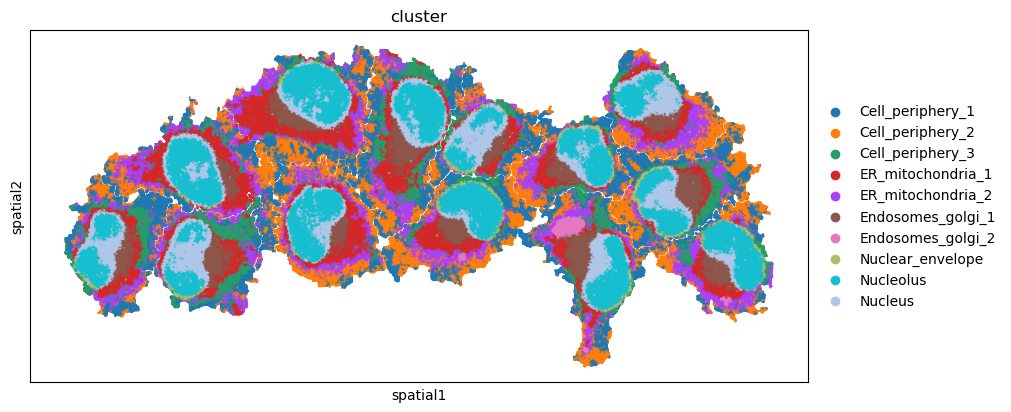

In [4]:
sq.pl.spatial_scatter(
    adata, color="cluster", shape=None, figsize=(10, 10)
)

/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:22<00:00, 45.12/s]
/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


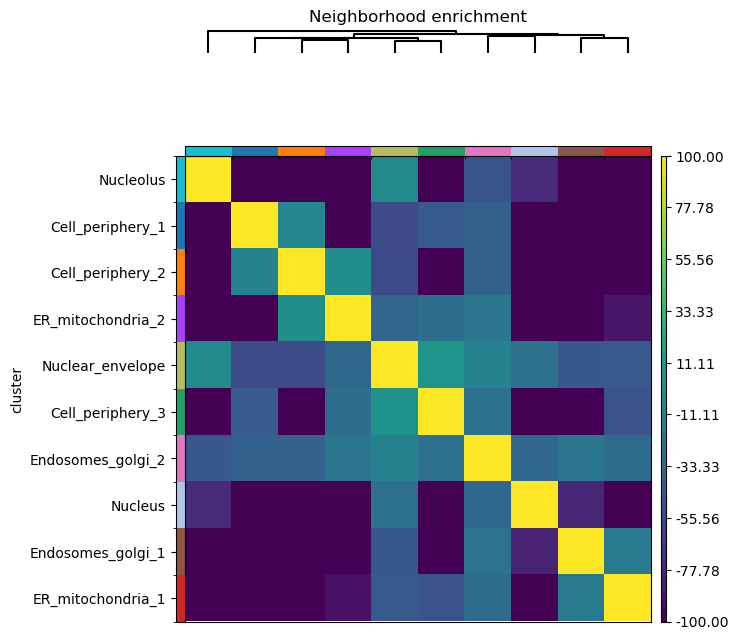

In [5]:
# Build spatial neighbors graph
sq.gr.spatial_neighbors(adata, coord_type="generic")
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster", method="ward", vmin=-100, vmax=100)

The squidpy tutorial allows calculating the neighborhood enrichment score for the entire sample. However, we may only be interested in a region of the image, for example, only around the three cells on the left. Spatialcells simplifies the region annotation, while providing convenient methods for region-based quantification.

In [6]:
adata.obs["X_centroid"] = adata.obsm["spatial"][:, 0]
adata.obs["Y_centroid"] = adata.obsm["spatial"][:, 1]
adata.obs

,x,y,is_nucleous,is_cytplasm,cell_id,leiden,cluster,X_centroid,Y_centroid
908860,1777,1201,False,True,140,1,Cell_periphery_1,1777,1201
682735,1447,982,True,False,118,5,Nucleus,1447,982
806699,2089,1104,False,True,136,7,Endosomes_golgi_1,2089,1104
790375,1306,1089,True,False,127,0,Nucleolus,1306,1089
835641,1902,1133,False,True,142,4,ER_mitochondria_2,1902,1133
...,...,...,...,...,...,...,...,...,...
961485,1364,1246,False,True,143,1,Cell_periphery_1,1364,1246
806705,2095,1104,False,True,136,7,Endosomes_golgi_1,2095,1104
603424,1386,909,False,True,118,2,Cell_periphery_2,1386,909
839951,2033,1137,True,False,136,0,Nucleolus,2033,1137


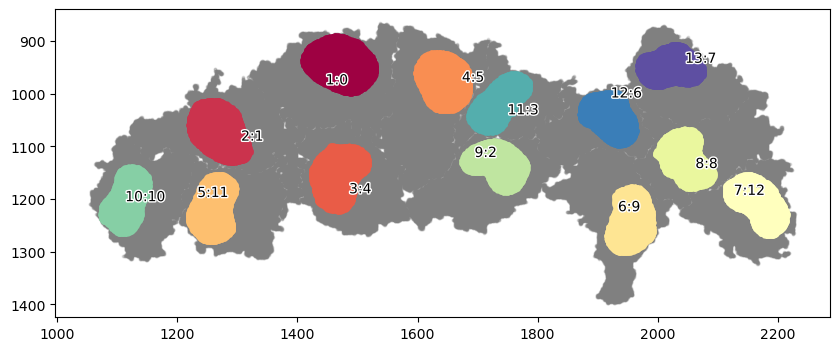

In [7]:
marker = ["is_nucleous"]
communitycolumn = "Nucleolus"
ret = spc.spatial.getCommunities(adata, marker, eps=10, newcolumn=communitycolumn)

fig, ax = plt.subplots(figsize=(10, 4))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=20, s=2, fontsize=10, ax=ax
)
ax.invert_yaxis()
plt.show()

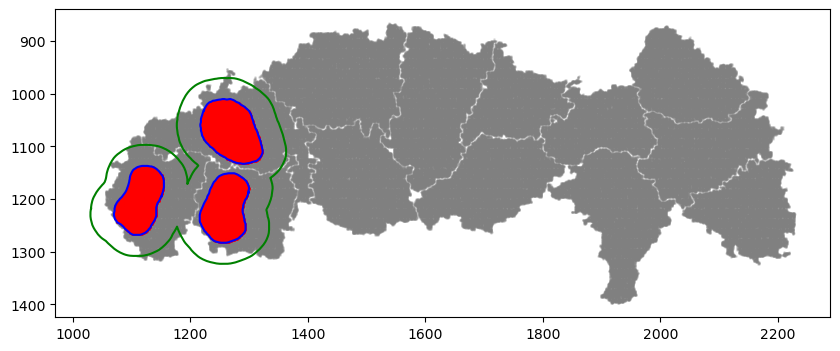

In [8]:
# selecting cells of interest: the three cells on the left
communityIndexList = [1, 10, 11]
boundary = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=10
)
roi_boundary = spc.spa.getExtendedBoundary(boundary, offset=40)

markersize = 1
fig, ax = plt.subplots(figsize=(10, 4))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="b")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")
ax.invert_yaxis()
plt.show()

45636it [00:02, 19639.93it/s]


Assigned points to region: Nucleolus


40441it [00:01, 24158.65it/s]


Assigned points to region: Nucleolus_ROI


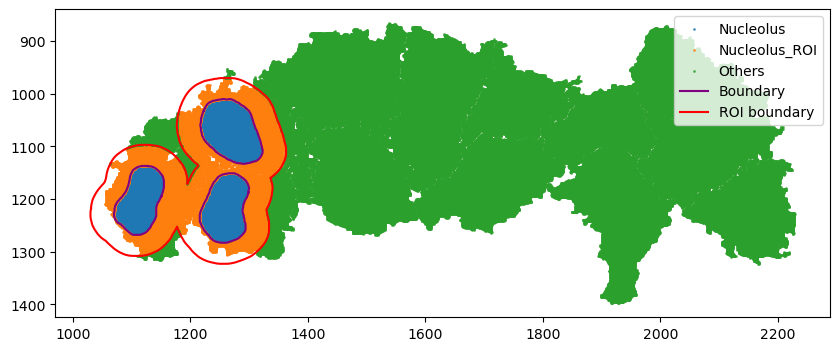

In [9]:
spc.spatial.assignPointsToRegions(
    adata,
    [boundary, roi_boundary],
    ["Nucleolus", "Nucleolus_ROI"],
    assigncolumn="region",
    default="Others",
)

point_size = 1
fig, ax = plt.subplots(figsize=(10, 4))
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.7,
        label=region
    )
# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="purple")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="r")
plt.legend(loc="upper right")
ax.invert_yaxis()
plt.show()

/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
100%|██████████| 1000/1000 [00:08<00:00, 117.28/s]
/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


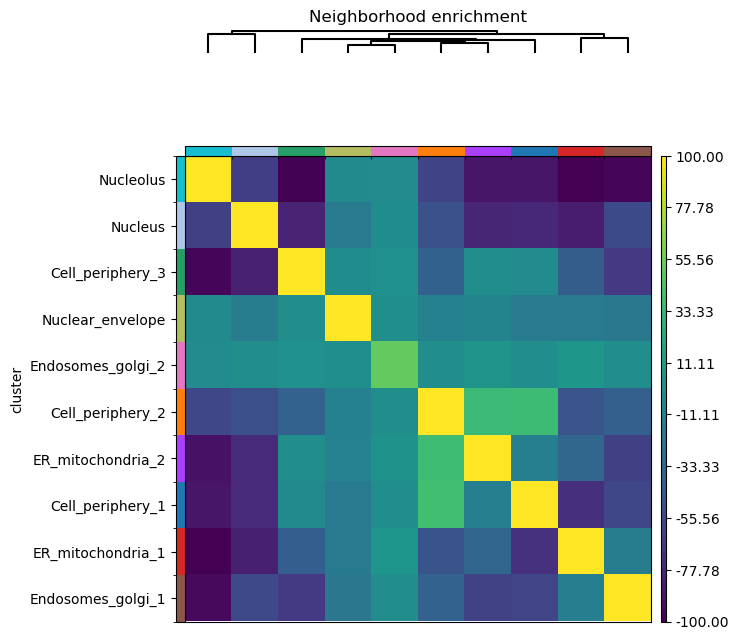

In [10]:
roi_adata = adata[adata.obs.region != "Others"].copy()
roi_adata.obsm["spatial"] = np.array(roi_adata.obs[["X_centroid", "Y_centroid"]])

sq.gr.spatial_neighbors(roi_adata, coord_type="generic")
sq.gr.nhood_enrichment(roi_adata, cluster_key="cluster")
sq.pl.nhood_enrichment(roi_adata, cluster_key="cluster", method="ward", vmin=-100, vmax=100)

Quantifying the protein composition within each region

In [11]:
nucleolus_comp = spc.msmt.getRegionComposition(adata, "cluster", regions=["Nucleolus"])
nucleolus_comp.rename(columns={"cell_count": "protein_count"}, inplace=True)
nucleolus_comp

,cluster,protein_count,composition
0,Nucleolus,10883,0.540528
1,Nucleus,8035,0.399076
2,Endosomes_golgi_1,534,0.026522
3,Nuclear_envelope,316,0.015695
4,ER_mitochondria_1,306,0.015198
5,Cell_periphery_3,57,0.002831
6,Endosomes_golgi_2,2,0.000099
7,ER_mitochondria_2,1,0.000050
8,Cell_periphery_1,0,0.000000
9,Cell_periphery_2,0,0.000000


In [12]:
roi_comp = spc.msmt.getRegionComposition(adata, "cluster", regions=["Nucleolus_ROI"])
roi_comp.rename(columns={"cell_count": "protein_count"}, inplace=True)
roi_comp

,cluster,protein_count,composition
0,ER_mitochondria_1,7690,0.256376
1,Cell_periphery_3,5687,0.189598
2,ER_mitochondria_2,4836,0.161227
3,Endosomes_golgi_1,4643,0.154792
4,Cell_periphery_1,4495,0.149858
5,Cell_periphery_2,2117,0.070578
6,Nuclear_envelope,278,0.009268
7,Nucleus,232,0.007735
8,Nucleolus,12,0.000400
9,Endosomes_golgi_2,5,0.000167


In [13]:
combined_comp = spc.msmt.getRegionComposition(adata, "cluster", regions=["Nucleolus", "Nucleolus_ROI"])
combined_comp.rename(columns={"cell_count": "protein_count"}, inplace=True)
combined_comp

,cluster,protein_count,composition
0,Nucleolus,10895,0.217339
1,Nucleus,8267,0.164915
2,ER_mitochondria_1,7996,0.159508
3,Cell_periphery_3,5744,0.114584
4,Endosomes_golgi_1,5177,0.103274
5,ER_mitochondria_2,4837,0.096491
6,Cell_periphery_1,4495,0.089669
7,Cell_periphery_2,2117,0.042231
8,Nuclear_envelope,594,0.011849
9,Endosomes_golgi_2,7,0.000140


Comparison with the protein composition of the entire sample.

In [14]:
overall_comp = spc.msmt.getRegionComposition(adata, "cluster")
overall_comp.rename(columns={"cell_count": "protein_count"}, inplace=True)
overall_comp

,cluster,protein_count,composition
0,Nucleolus,51802,0.191239
1,Cell_periphery_1,37885,0.139861
2,Cell_periphery_2,36226,0.133736
3,ER_mitochondria_1,33660,0.124264
4,ER_mitochondria_2,32378,0.119531
5,Nucleus,28458,0.105059
6,Cell_periphery_3,22788,0.084127
7,Endosomes_golgi_1,22402,0.082702
8,Nuclear_envelope,3674,0.013563
9,Endosomes_golgi_2,1603,0.005918
